#  Sentiment analysis, Visualization and Wordcloud of Covid-19 Tweets

In [1]:
import numpy as np
import pandas as pd 
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display

import re
import string

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
nltk.download('stopwords')
nltk.download('vader_lexicon')

from collections import Counter

from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns

sns.set(style="darkgrid")

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Visualizing and Understading of Data

In [2]:
df = pd.read_csv('../input/covid19-tweets/covid19_tweets.csv')

In [3]:
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_name         179108 non-null  object
 1   user_location     142337 non-null  object
 2   user_description  168822 non-null  object
 3   user_created      179108 non-null  object
 4   user_followers    179108 non-null  int64 
 5   user_friends      179108 non-null  int64 
 6   user_favourites   179108 non-null  int64 
 7   user_verified     179108 non-null  bool  
 8   date              179108 non-null  object
 9   text              179108 non-null  object
 10  hashtags          127774 non-null  object
 11  source            179031 non-null  object
 12  is_retweet        179108 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 15.4+ MB


For the feature in the dataset:

user_name - contains the user name

user_location - contains the user's loaction

user_description - the user description on Tweeter

user_created - the user id created time.

user_followers - It conatins the followers of users

user_friends - It contains the user's friends on Tweeter

user_favourites - It conatins user's favourites on Tweeter.

user_verified - User is verified or not ( True / False )

date - Date of Tweet

text - Text of Tweet

hashtags - how many hashtags the tweet have.

source - It contains the source of that.

is_retweet - Any retweets it have or not ( True / False ).

### Find the missing values

In [5]:
missed = round(df.isnull().sum() * 100/ len(df), 2).sort_values()
missed = missed[missed > 0]

missed_df = pd.DataFrame()
missed_df['feature'] = missed.index
missed_df['precent'] = missed.values

fig = px.bar(missed_df, 
             x=missed_df['precent'], 
             y=missed_df['feature'],
             height=400, width=600,
            title='Missed values percent for columns',
             color = 'feature'
            )


fig.show()

### Find the user who is popular and how many tweets about Covid-19 they sent

In [6]:
ds = df['user_name'].value_counts().reset_index()
ds.columns = ['user_name', 'tweets_count']
ds = ds.sort_values(['tweets_count'])
df = pd.merge(df, ds, on='user_name', how='inner')

In [7]:
data = df.sort_values('user_followers', ascending=False)
data = data.drop_duplicates(subset='user_name', keep="first")
data = data[['user_name', 'user_followers', 'tweets_count']]
data = data.sort_values('user_followers')

fig = px.bar(
    data.tail(40), 
    x='user_followers',
    y='user_name', 
    color='tweets_count',
    title='Top 40 users by number of followers', 
    width=600, 
    height=800
)
fig.show()

In [8]:
pd.to_datetime(df['user_created'])

0        2017-05-26 05:46:42
1        2017-05-26 05:46:42
2        2009-04-16 20:06:23
3        2009-02-28 18:57:41
4        2009-02-28 18:57:41
                 ...        
179103   2015-05-27 16:35:15
179104   2010-01-07 18:19:37
179105   2008-12-31 16:16:12
179106   2013-12-30 18:59:19
179107   2018-04-14 17:30:07
Name: user_created, Length: 179108, dtype: datetime64[ns]

### Find how many new users 

In [9]:
df['year_created'] = pd.to_datetime(df['user_created']).dt.year
data = df.drop_duplicates(subset='user_name', keep="first")
data = data[data['year_created']>2006]
data = data['year_created'].value_counts().reset_index()
data.columns = ['year', 'number']

fig = px.bar(
    data, 
    x="year", 
    y="number", 
    orientation='v', 
    title='User created year by year', 
    width=800, 
    height=600
)

fig.show()

### Find Top-30 users who sent most tweets

In [10]:
ds = df['user_name'].value_counts().reset_index()
ds.columns = ['user_name', 'tweets_count']
ds = ds.sort_values(['tweets_count'])

fig = px.bar(
    ds.tail(30), 
    x='tweets_count', 
    y='user_name',
    width=800, 
    height=800,
    title='Top 30 users by number of tweets'
    )

fig.show()

### List Top Countries or places sent most tweets

In [11]:
ds = df['user_location'].value_counts().reset_index()
ds.columns = ['user_location', 'count']
ds = ds.sort_values(['count'])

fig = px.bar(
    ds.tail(40), 
    x="count", 
    y="user_location", 
    orientation='h', title='Top 40 user locations by number of tweets', 
    width=600, 
    height=600
)

fig.show()

It can be found that Data concentration countries and parts are related to relationships, such as "Washington DC" and "US" have been counted as different countries. Therefore, the introduction of the world city list to re-statistically

In [12]:
cities = pd.read_csv('../input/world-cities-datasets/worldcities.csv')
covid_tweets_data = pd.read_csv('../input/covid19-tweets/covid19_tweets.csv')
covid_tweets_data["location"] = covid_tweets_data["user_location"]
covid_tweets_data["country"] = np.NaN
user_location = covid_tweets_data['location'].fillna(value='').str.split(',')

In [13]:
lat = cities['lat'].fillna(value = '').values.tolist()
lng = cities['lng'].fillna(value = '').values.tolist()
country = cities['country'].fillna(value = '').values.tolist()

# Getting all alpha 3 codes into  a list
world_city_iso3 = []
for c in cities['iso3'].str.lower().str.strip().values.tolist():
    if c not in world_city_iso3:
        world_city_iso3.append(c)
        
# Getting all alpha 2 codes into  a list    
world_city_iso2 = []
for c in cities['iso2'].str.lower().str.strip().values.tolist():
    if c not in world_city_iso2:
        world_city_iso2.append(c)
        
# Getting all countries into  a list        
world_city_country = []
for c in cities['country'].str.lower().str.strip().values.tolist():
    if c not in world_city_country:
        world_city_country.append(c)

# Getting all amdin names into  a list
world_states = []
for c in cities['admin_name'].str.lower().str.strip().tolist():
    world_states.append(c)


# Getting all cities into  a list
world_city = cities['city'].fillna(value = '').str.lower().str.strip().values.tolist()

In [14]:
for each_loc in range(len(user_location)):
    ind = each_loc
    each_loc = user_location[each_loc]
    for each in each_loc:
        each = each.lower().strip()
        if each in world_city:
            order = world_city.index(each)
            covid_tweets_data['country'][ind] = country[order]
            continue
        if each in world_states:
            order= world_states.index(each)
            covid_tweets_data['country'][ind] = country[order]
            continue
        if each in world_city_country:
            order = world_city_country.index(each)
            covid_tweets_data['country'][ind] = world_city_country[order]
            continue
        if each in world_city_iso2:
            order = world_city_iso2.index(each)
            covid_tweets_data['country'][ind] = world_city_country[order]
            continue
        if each in world_city_iso3:
            order = world_city_iso3.index(each)
            covid_tweets_data['country'][ind] = world_city_country[order]
            continue

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is tr

In [15]:
tweet_per_country = covid_tweets_data['country'].str.lower().dropna()
tw = tweet_per_country.value_counts().rename_axis('Country').reset_index(name='Tweet Count')
country_graph=px.bar(x='Tweet Count',y='Country',data_frame=tw[:15],color='Country')
country_graph.show()

It can be found that the discussion of the epidemic in the United States, India is much higher than other countries, which is in line with the world's epidemic.

### Top-40 sources by the number of tweets. (Equipment used to use Twitter)

In [16]:
ds = df['source'].value_counts().reset_index()
ds.columns = ['source', 'count']
ds = ds.sort_values(['count'])

fig = px.bar(
    ds.tail(40), 
    x="count", 
    y="source", 
    orientation='h', 
    title='Top 40 user sources by number of tweets', 
    width=800, 
    height=800
)

fig.show()

### Statistics During the dataset time, the transition frequency change is changed over time.

Split day and time into separate columns.

In [17]:
df['date'] = pd.to_datetime(df['date']) 
df = df.sort_values(['date'])
df['day'] = df['date'].astype(str).str.split(' ', expand=True)[0]
df['time'] = df['date'].astype(str).str.split(' ', expand=True)[1]
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,tweets_count,year_created,day,time
55192,Jessica Luther Rummel,"Denton, Texas",Mother. Partner. Scholar. Activist. Alchemist....,2020-07-05 03:28:16,234,28,220,False,2020-07-24 23:47:08,PROTESTORS NEEDED 6PM-10PM DAILY (NOW). 1450 E...,NaN,Twitter Web App,False,1,2020,2020-07-24,23:47:08
50894,Patty Hayes,"Seattle, WA",Director of Public Health - Seattle & King Cou...,2017-07-07 18:56:50,718,162,2276,False,2020-07-24 23:47:12,"Excellent partnership to prevent #COVID19, tha...",['COVID19'],Twitter for Android,False,2,2017,2020-07-24,23:47:12
55189,Clive Gorman,"Victoria, British Columbia",Marketing Director @CNEGames for @idlechampion...,2011-12-23 02:02:35,597,224,23824,False,2020-07-24 23:47:12,Don't take your eye off the ball. There are st...,['COVID19'],Twitter for Android,False,2,2011,2020-07-24,23:47:12
55191,Dr. Lipi #TrustDrFauci Roy,"New York, USA",@NBCNews @MSNBC @Forbes Medical Contributor | ...,2009-10-11 18:46:51,12485,4603,38120,True,2020-07-24 23:47:12,Always honored to speak w @NicolleDWallace abo...,['covid19'],Twitter Web App,False,1,2009,2020-07-24,23:47:12
55188,Tristyn Russelo,"Alberta, Canada",NaN,2017-06-14 22:01:54,5,68,57,False,2020-07-24 23:47:13,"Apparently, at the Timberlea @saveonfoods stor...",NaN,Twitter Web App,False,1,2017,2020-07-24,23:47:13


#### Check how many tweets for every day in dataset.

In [18]:
ds = df['day'].value_counts().reset_index()
ds.columns = ['day', 'count']
ds = ds.sort_values('count')
ds['day'] = ds['day'].astype(str) + ':00:00:00'

fig = px.bar(
    ds, 
    x='count', 
    y="day", 
    title='Tweets distribution over days present in dataset', 
    width=800, 
    height=800
)
fig.show()

#### Check how many tweets sent in 1 day (24 hours)

In [19]:
df['hour'] = df['date'].dt.hour
ds = df['hour'].value_counts().reset_index()
ds.columns = ['hour', 'count']
ds = ds.sort_values('hour')
ds['hour'] = 'Hour ' + ds['hour'].astype(str)
fig = px.line(
    ds, 
    x="hour", 
    y="count", 
    orientation='v', 
    title='Tweets distribution over hours', 
    width=1000
)
fig.show()

## Data pre-prosecessing

In [20]:
df=pd.read_csv('../input/covid19-tweets/covid19_tweets.csv')

In [21]:
cl=['user_name','date','text']
df=df[cl]
df.head()

,user_name,date,text
0,ᏉᎥ☻լꂅϮ,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...
1,Tom Basile 🇺🇸,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2,Time4fisticuffs,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...
3,ethel mertz,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...
4,DIPR-J&K,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...



#### change the type of some columns

In [22]:
df.user_name=df.user_name.astype('category')
df.user_name=df.user_name.cat.codes # assign a unique numerical code to each category
df.date=pd.to_datetime(df.date).dt.date

df.head(5)


,user_name,date,text
0,89755,2020-07-25,If I smelled the scent of hand sanitizers toda...
1,76403,2020-07-25,Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2,76147,2020-07-25,@diane3443 @wdunlap @realDonaldTrump Trump nev...
3,84572,2020-07-25,@brookbanktv The one gift #COVID19 has give me...
4,18398,2020-07-25,25 July : Media Bulletin on Novel #CoronaVirus...


#### Extract data that is only the text

In [23]:
texts=df.text
texts

0         If I smelled the scent of hand sanitizers toda...
1         Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2         @diane3443 @wdunlap @realDonaldTrump Trump nev...
3         @brookbanktv The one gift #COVID19 has give me...
4         25 July : Media Bulletin on Novel #CoronaVirus...
                                ...                        
179103    Thanks @IamOhmai for nominating me for the @WH...
179104    2020! The year of insanity! Lol! #COVID19 http...
179105    @CTVNews A powerful painting by Juan Lucena. I...
179106    More than 1,200 students test positive for #CO...
179107    I stop when I see a Stop\n\n@SABCNews\n@Izinda...
Name: text, Length: 179108, dtype: object

#### Remove Urls

In [24]:
remove_url=lambda x:re.sub(r'http\S+','',str(x))
texts_lr=texts.apply(remove_url)
texts_lr

0         If I smelled the scent of hand sanitizers toda...
1         Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2         @diane3443 @wdunlap @realDonaldTrump Trump nev...
3         @brookbanktv The one gift #COVID19 has give me...
4         25 July : Media Bulletin on Novel #CoronaVirus...
                                ...                        
179103    Thanks @IamOhmai for nominating me for the @WH...
179104           2020! The year of insanity! Lol! #COVID19 
179105    @CTVNews A powerful painting by Juan Lucena. I...
179106    More than 1,200 students test positive for #CO...
179107    I stop when I see a Stop\n\n@SABCNews\n@Izinda...
Name: text, Length: 179108, dtype: object

#### Set all be lower case

In [25]:
to_lower=lambda x: x.lower()
texts_lr_lc=texts_lr.apply(to_lower)
texts_lr_lc

0         if i smelled the scent of hand sanitizers toda...
1         hey @yankees @yankeespr and @mlb - wouldn't it...
2         @diane3443 @wdunlap @realdonaldtrump trump nev...
3         @brookbanktv the one gift #covid19 has give me...
4         25 july : media bulletin on novel #coronavirus...
                                ...                        
179103    thanks @iamohmai for nominating me for the @wh...
179104           2020! the year of insanity! lol! #covid19 
179105    @ctvnews a powerful painting by juan lucena. i...
179106    more than 1,200 students test positive for #co...
179107    i stop when i see a stop\n\n@sabcnews\n@izinda...
Name: text, Length: 179108, dtype: object

#### Removing punctuations

In [26]:
remove_puncs= lambda x:x.translate(str.maketrans('','',string.punctuation))
texts_lr_lc_np=texts_lr_lc.apply(remove_puncs)
texts_lr_lc_np

0         if i smelled the scent of hand sanitizers toda...
1         hey yankees yankeespr and mlb  wouldnt it have...
2         diane3443 wdunlap realdonaldtrump trump never ...
3         brookbanktv the one gift covid19 has give me i...
4         25 july  media bulletin on novel coronavirusup...
                                ...                        
179103    thanks iamohmai for nominating me for the who ...
179104               2020 the year of insanity lol covid19 
179105    ctvnews a powerful painting by juan lucena its...
179106    more than 1200 students test positive for covi...
179107    i stop when i see a stop\n\nsabcnews\nizindaba...
Name: text, Length: 179108, dtype: object

#### Removing stopwords

In [27]:
more_words=['say','going','like','U','u','yankees','diane3443','today','hey','covid','#coronavirus', '#coronavirusoutbreak', '#coronavirusPandemic', '#covid19', '#covid_19', '#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 'covid19']
stop_words=set(stopwords.words('english')) #nltk package
stop_words.update(more_words)

remove_words=lambda x: ' '.join([word for word in x.split() if word not in stop_words]) #.join is from package string
texts_lr_lc_np_ns=r=texts_lr_lc_np.apply(remove_words)
texts_lr_lc_np_ns

0         smelled scent hand sanitizers someone past wou...
1         yankeespr mlb wouldnt made sense players pay r...
2         wdunlap realdonaldtrump trump never claimed ho...
3         brookbanktv one gift give appreciation simple ...
4         25 july media bulletin novel coronavirusupdate...
                                ...                        
179103    thanks iamohmai nominating wearamask challenge...
179104                               2020 year insanity lol
179105    ctvnews powerful painting juan lucena tribute ...
179106    1200 students test positive major university a...
179107    stop see stop sabcnews izindabanews24 dailysun...
Name: text, Length: 179108, dtype: object

#### Addtional clean, special signals


In [28]:
df.text=texts_lr_lc_np_ns

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
df['text'] = df['text'].apply(lambda x: clean_text(x))
display(df)

,user_name,date,text
0,89755,2020-07-25,smelled scent hand sanitizers someone past wou...
1,76403,2020-07-25,yankeespr mlb wouldnt made sense players pay r...
2,76147,2020-07-25,wdunlap realdonaldtrump trump never claimed ho...
3,84572,2020-07-25,brookbanktv one gift give appreciation simple ...
4,18398,2020-07-25,july media bulletin novel coronavirusupdates ...
...,...,...,...
179103,2024,2020-08-29,thanks iamohmai nominating wearamask challenge...
179104,36471,2020-08-29,year insanity lol
179105,8688,2020-08-29,ctvnews powerful painting juan lucena tribute ...
179106,28623,2020-08-29,students test positive major university abc news


In [29]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [30]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))
display(df)

,user_name,date,text
0,89755,2020-07-25,smelled scent hand sanitizers someone past wou...
1,76403,2020-07-25,yankeespr mlb wouldnt made sense players pay r...
2,76147,2020-07-25,wdunlap realdonaldtrump trump never claimed ho...
3,84572,2020-07-25,brookbanktv one gift give appreciation simple ...
4,18398,2020-07-25,july media bulletin novel coronavirusupdates ...
...,...,...,...
179103,2024,2020-08-29,thanks iamohmai nominating wearamask challenge...
179104,36471,2020-08-29,year insanity lol
179105,8688,2020-08-29,ctvnews powerful painting juan lucena tribute ...
179106,28623,2020-08-29,students test positive major university abc news


### Use Google Translation API to translate other languages ​​in the essay into English

In [31]:
!pip install google_trans_new

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [32]:
from google_trans_new import google_translator  
translator = google_translator()

trans1=translator.translate('आयुर्वेदगौरवआचार्यबालकृष्ण', lang_tgt='en')
print(trans1)
trans2=translator.translate('കണ്ടെയ്മെൻറ്സോണുകൾ', lang_tgt='en')
print(trans2)

Ayurveda Gaurav Acharya Balkrishna 
Containsons 


## Here is the sample that How to use google translate to let all tweets english, commenly Translate API cannot slove too many requests at one time

In [33]:
# j = 0
# for i in df['text']:
#     print(df['text'][j])
#     df['text'][j] = translator.translate(i, lang_tgt='en')
#     print(df['text'][j])
#     j = j+1
# df['text']

### Count high friquent words out of all the tweets

In [34]:
words_list=[word for line in texts_lr_lc_np_ns for word in line.split()]
word_counts=Counter(words_list).most_common(50)
word_df=pd.DataFrame(word_counts)
word_df.columns=['word','frq']
display(word_df.head(5))
# px=import plotly.express
px.bar(word_df,x='word',y='frq',title='Most common words')

,word,frq
0,cases,18596
1,new,14683
2,people,9053
3,pandemic,7869
4,deaths,7429


## Words Cloud

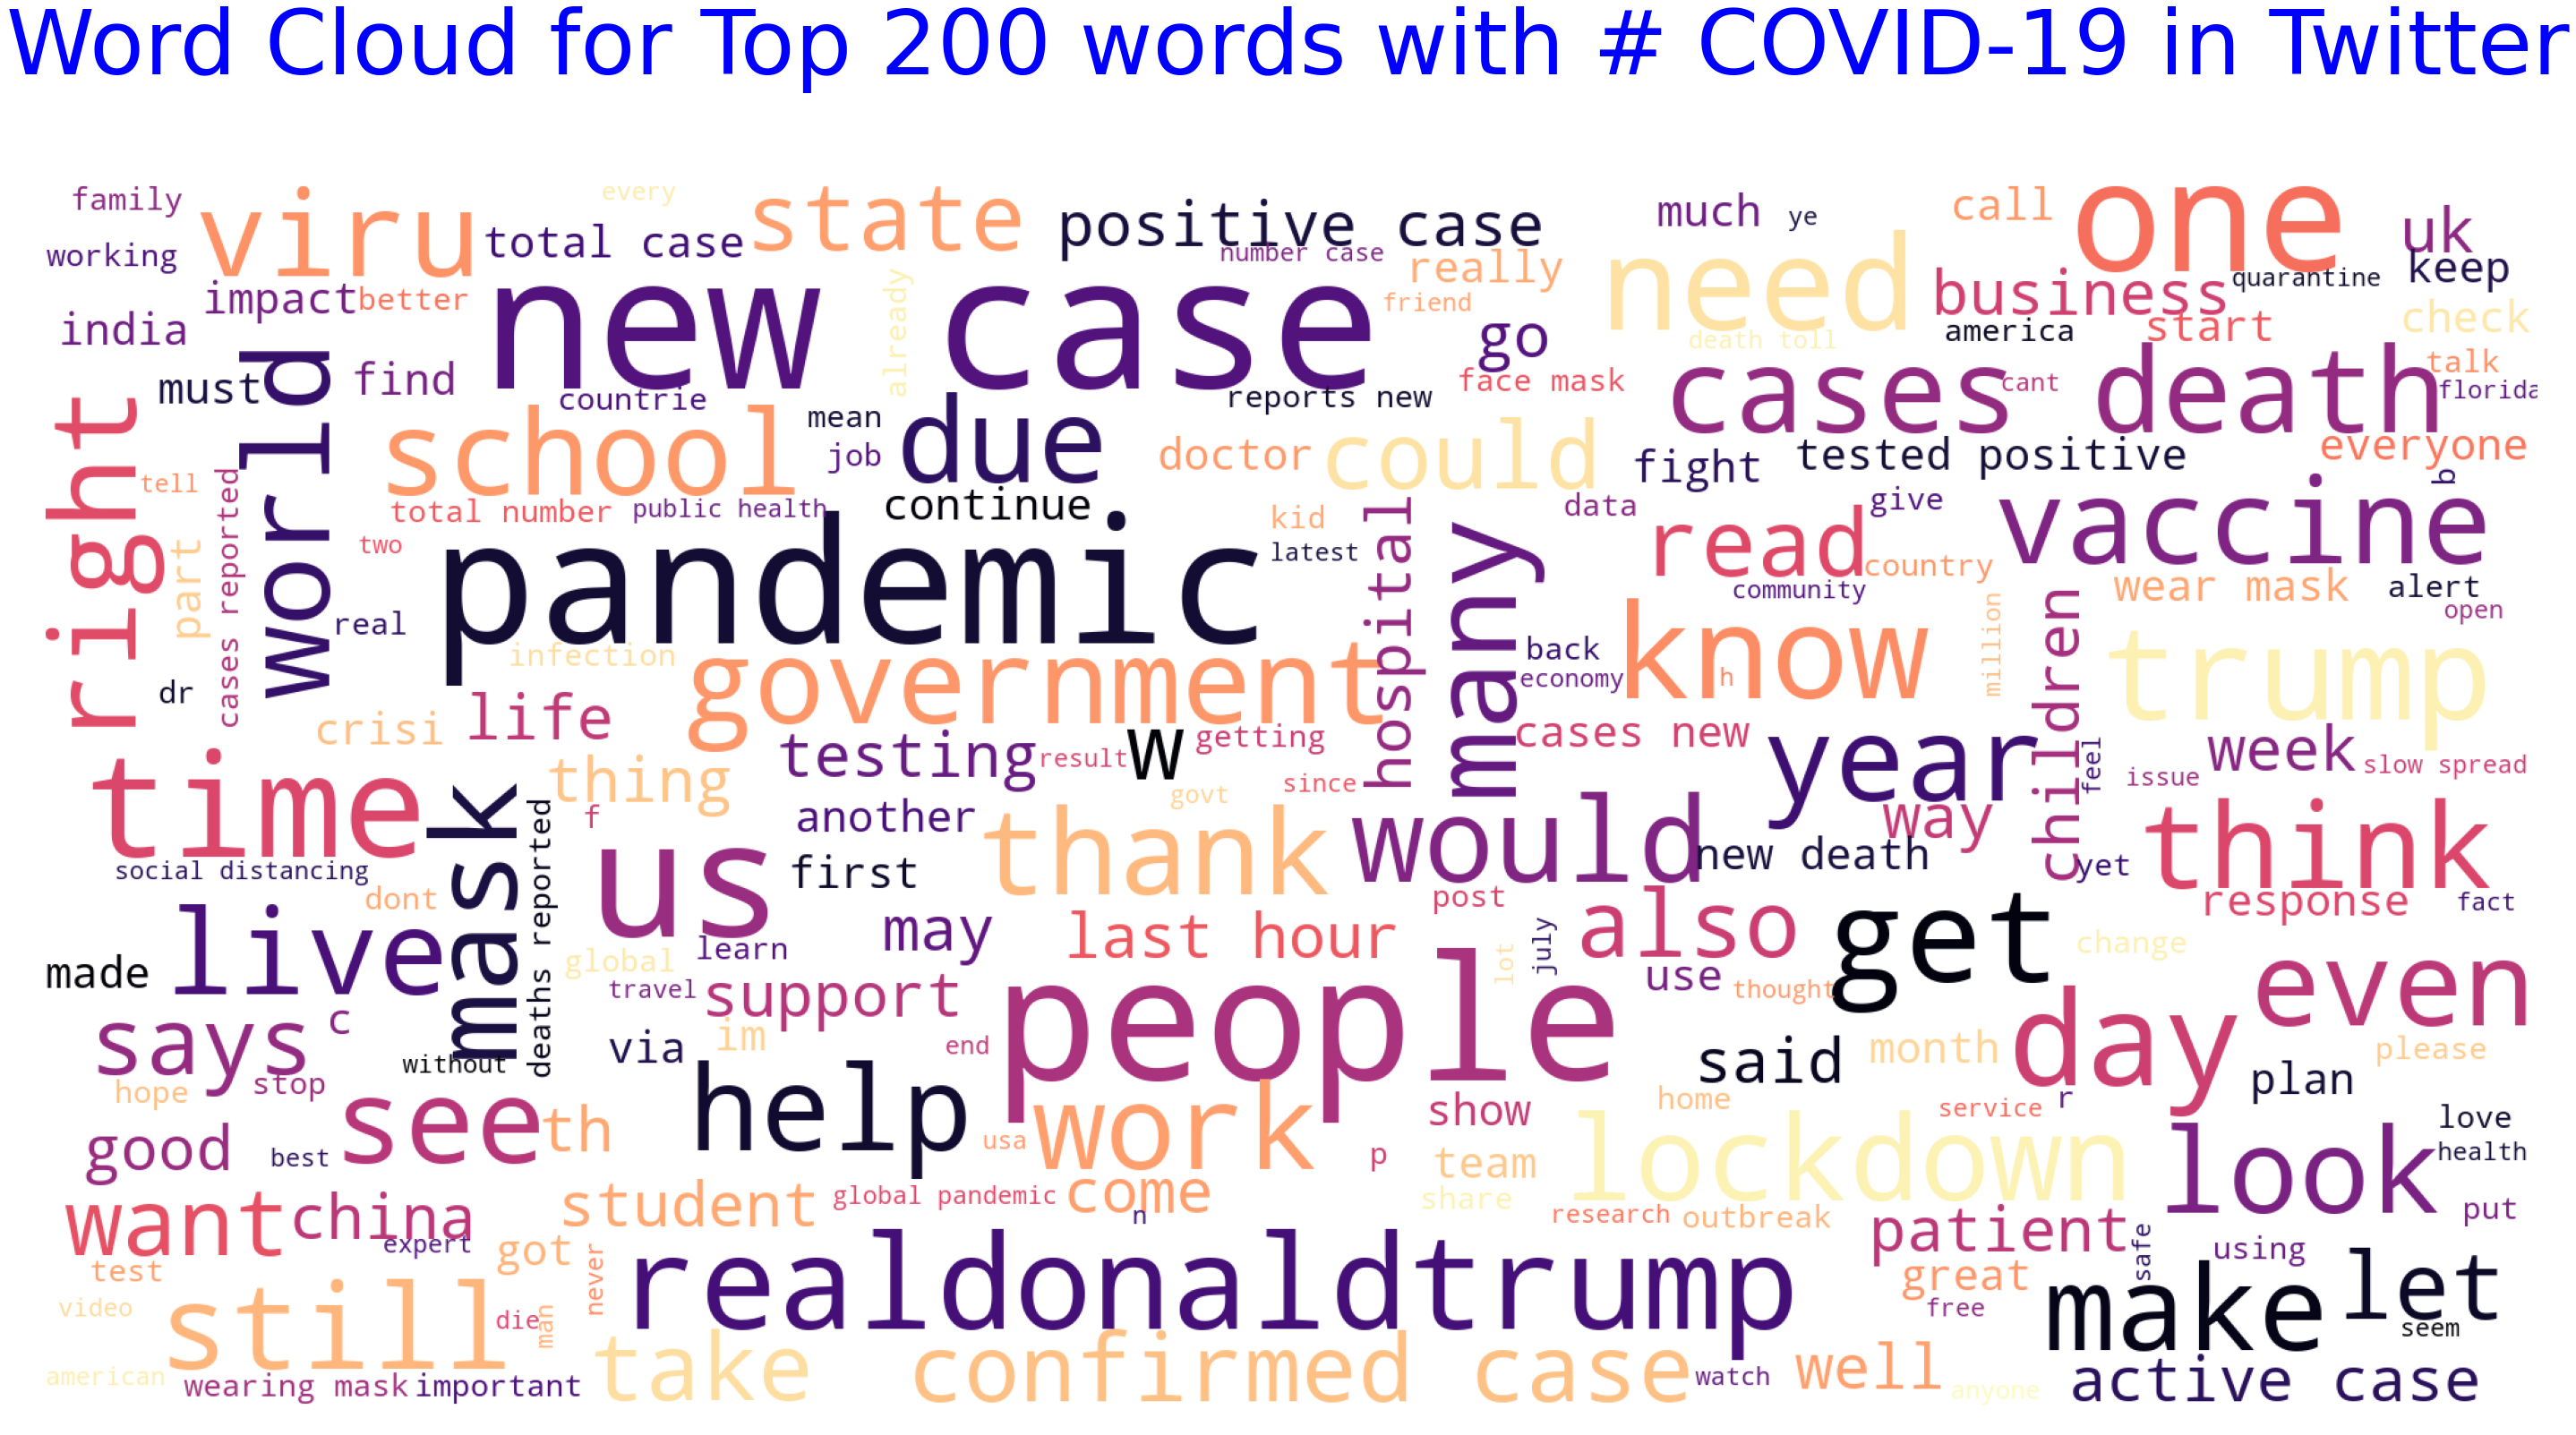

In [35]:
from wordcloud import WordCloud

cut_text = " ".join(df.text)
max_words=200
word_cloud = WordCloud(
                    background_color='white',
                    stopwords=set(stop_words),
                    max_words=max_words,
                    max_font_size=30,
                    scale=5,
    colormap='magma',
                    random_state=1).generate(cut_text)
fig = plt.figure(1, figsize=(50,50))
plt.axis('off')
plt.title('Word Cloud for Top '+str(max_words)+' words with # COVID-19 in Twitter\n', fontsize=100,color='blue')
fig.subplots_adjust(top=2.3)
plt.imshow(word_cloud)
plt.show()

## Using Google Cloud NLP API do Sentiment analysis

In [36]:
results =pd.read_csv('../input/mydata/mydata.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.



In [37]:
results = results[['text','score','magnitude']]
results = results.dropna()
results.head()

,text,score,magnitude
1,smelled scent hand sanitizers someone past wou...,-70.0%,70.0%
2,yankeespr mlb wouldnt made sense players pay r...,-70.0%,70.0%
3,wdunlap realdonaldtrump trump never claimed ho...,-60.0%,60.0%
4,brookbanktv one gift give appreciation simple ...,80.0%,80.0%
5,july media bulletin novel coronavirusupdates ...,20.0%,20.0%


In [38]:
score_counts=Counter(results['score'])
score_counts=pd.DataFrame([score_counts])
score_counts = score_counts.T
score_counts = score_counts.reset_index()
score_counts.columns = ['percent','num']
score_counts = score_counts.drop(score_counts[score_counts['percent'] == 'score'].index)
score_counts['percent'] = score_counts['percent'].apply(lambda x: x.replace('%', '')).astype('float')
score_counts = score_counts.sort_values(by = 'percent')


print(score_counts)

fig = px.bar(
    score_counts, 
    x="percent", 
    y="num", 
    orientation='v', 
    title='Count the number of each emotion score of Tweets', 
    width=800, 
    height=600,
    color = 'percent'
)

fig.show()

    percent    num
17    -90.0    853
4     -80.0   7974
0     -70.0  10761
1     -60.0   9862
13    -50.0   9580
7     -40.0   9249
11    -30.0   9306
6     -20.0   9841
10    -10.0  10580
5       0.0  23829
8      10.0   9176
3      20.0   7057
9      30.0   5187
16     40.0   4016
14     50.0   3711
15     60.0   3027
12     70.0   2884
2      80.0   3209
18     90.0   2882


Emotional score is between -1.0 (negative) and 1.0 (positive), corresponding to the overall emotional tendency of the text.
It can be found that most people are still calm. However, for unconception groups, negative emotions slightly more active emotions

In [39]:
magnitude_counts=Counter(results['magnitude'])
magnitude_counts=pd.DataFrame([magnitude_counts])
magnitude_counts = magnitude_counts.T
magnitude_counts = magnitude_counts.reset_index()
magnitude_counts.columns = ['percent','num']
magnitude_counts = magnitude_counts.drop(magnitude_counts[magnitude_counts['percent'] == 'magnitude'].index)
magnitude_counts['percent'] = magnitude_counts['percent'].apply(lambda x: x.replace('%', '')).astype('float')
magnitude_counts = magnitude_counts.sort_values(by = 'percent')


print(magnitude_counts)

fig = px.bar(
    magnitude_counts, 
    x="percent", 
    y="num", 
    orientation='v', 
    title='Count the number of each emotion magnitude of Tweets', 
    width=800, 
    height=600,
    color = 'percent'
)

fig.show()

    percent    num
4       0.0  23725
6      10.0  19698
3      20.0  16859
7      30.0  14488
5      40.0  13270
8      50.0  13292
1      60.0  12938
0      70.0  13662
2      80.0  11204
9      90.0   3752
11    100.0     20
19    110.0      9
16    120.0     10
14    130.0      8
15    140.0     12
17    150.0      2
12    160.0     10
24    170.0      6
25    180.0      1
18    190.0      5
20    200.0      2
22    210.0      1
21    220.0      1
23    240.0      2
10    270.0      7


Magnitude indicates the overall strength of the given text (including positive and negative), between 0.0 and + INF. Unlike score, Magnitude is not normalized; each emotional expression in text (positive and negative) will affect the text of the text (so the length of the long text block may be large). (The bigger the influence higher)

From the figure, the vast majority of people have no violent emotions, and the people in the COVID-19 epidemic will not be in a very large negative.


## Conclusion

For COVID-19 related information, it can be found that a considerable number of people still held a conservative attitude. They did not show strong positive or negative emotions.

Except for those with conservative attitudes, COVID-19 has had a huge emotional impact on other people. But overall, there were more negative emotions than positive emotions.

Conclusion: For new products launched during the epidemic, our company should due to more positive psychological signals, such as using warm colors, soft fonts and border design, etc., expressing soothing for user psychology. System algorithm can be recommended more positive signals at 7 a.m. and 16 p.m. (ETS) every day to U.S., India and U.K. people.

May be interesting, solving the bad emotional content that the user is isolated at home